<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Kavindu-Deshanjana/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing nesassary libraries

In [36]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error, explained_variance_score
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

### Data Preprocessing

In [37]:
# Mounting the Google Drive
drive.mount('/content/drive')

# Load the preprocessed data
data = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx')

def onehot_encode(df, column, prefix):
    df = df.copy()

    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)

    return df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Training the Model


In [29]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop unnecessary columns
    columns_to_drop = ['Date', 'Code', 'Shift', 'Department', 'Absenteeism Type', 'Status', 'Leave Type',
                       'Absent/Present', 'Reason', 'Joined Date', 'TargetCategory', 'TookLeaveNextMonth']
    df = df.drop(columns_to_drop, axis=1)

    # One-hot encode the reason column
    df = onehot_encode(df, column='Encoded Reason', prefix='Reason')

    # Split df into X and y
    y = df['LeavesNextMonth'].copy()
    X = df.drop('LeavesNextMonth', axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

    return X_train, X_test, y_train, y_test

# Preprocess data
data = data[data['Date'] < '2023-12-01']
X_train, X_test, y_train, y_test = preprocess_inputs(data)

# Train the XGBoost regression model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_model.predict(X_test)

# Define a function to map predicted values to classes
def map_to_class(value):
    if value is None:
        return 'Unknown'
    elif value >= 2:
        return 'B'
    else:
        return 'A'

# Map predicted values to classes
predicted_classes = [map_to_class(value) for value in predictions]


# Make predictions on the test data
predictions_rf = xgb_model.predict(X_test)
actual_classes = [map_to_class(value) for value in y_test]

# Map predicted values to classes
predicted_classes_rf = [map_to_class(value) for value in predictions_rf]
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_rf})

# Create a DataFrame to display actual and predicted values
results_classified_df = pd.DataFrame({'Actual': actual_classes, 'Predicted': predicted_classes_rf})


# Map predicted values to classes
predicted_classes_rf = [map_to_class(value) for value in predictions_rf if value is not None]
actual_classes_filtered = [actual for idx, actual in enumerate(actual_classes) if predictions_rf[idx] is not None]


### Getting the feature importance graph

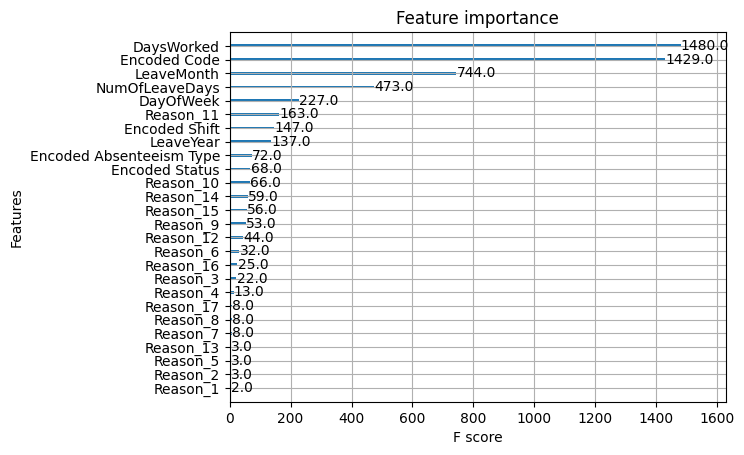

In [30]:
# Plot feature importance
plot_importance(xgb_model)
plt.show()

### R2 Value of the Model

In [31]:
# Calculate R-squared (R2)
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2): {r2:.2f}')

R-squared (R2): 0.56


### Accuracy Of the Model

In [33]:
# Calculate accuracy
accuracy_rf = accuracy_score(actual_classes_filtered, predicted_classes_rf)
print(f'Accuracy of Predicted Classes (XGBoost): {accuracy_rf*100:.2f}')

Accuracy of Predicted Classes (XGBoost): 66.73


### Actual vs Predictions of how many days each employeee will be absent in the folllowing month

In [34]:
print(results_df)

       Actual  Predicted
29176       0   1.509778
15446       1   5.726143
28579       0   0.969079
27999       0   1.434221
3763        0   2.794360
...       ...        ...
36030      16   4.634670
9579        0   4.342109
6868        1   6.416487
30861       7   2.617118
849         1   6.177671

[7949 rows x 2 columns]


### Actual vs Predictions of the class of the absent days each employeee gets for the folllowing month

In [35]:
# Display the DataFrame
print(results_classified_df)

     Actual Predicted
0         A         A
1         A         B
2         A         A
3         A         A
4         A         B
...     ...       ...
7944      B         B
7945      A         B
7946      A         B
7947      B         B
7948      A         B

[7949 rows x 2 columns]
